In [26]:
!pip install weightwatcher

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 5.2 MB/s eta 0:00:00


In [1]:
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import keras
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input,  Embedding, Dropout, Dense, BatchNormalization, Concatenate, LSTM, GlobalAveragePooling1D, Bidirectional, Add, Multiply
from tensorflow.keras.regularizers import L1L2, l2, l1
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Orthogonal
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.metrics import Recall, Precision
import tensorflow as tf
from tensorflow.keras.models import model_from_json
import matplotlib.pyplot as plt
import keras
import weightwatcher as ww

# Предобработка датасета

In [3]:
df = pd.read_csv("ml_ozon_╤Бounterfeit_train.csv")

In [4]:
print('Кол-во пропусков:\n')
print(df.isna().sum(), "\n\n")
print("Размерность датасета:")
print(df.shape)

Кол-во пропусков:

id                                   0
resolution                           0
brand_name                       80531
description                      26060
name_rus                             0
CommercialTypeName4                  0
rating_1_count                  150005
rating_2_count                  150005
rating_3_count                  150005
rating_4_count                  150005
rating_5_count                  150005
comments_published_count        150005
photos_published_count          150005
videos_published_count          150005
PriceDiscounted                      0
item_time_alive                      0
item_count_fake_returns7             0
item_count_fake_returns30            0
item_count_fake_returns90            0
item_count_sales7                    0
item_count_sales30                   0
item_count_sales90                   0
item_count_returns7                  0
item_count_returns30                 0
item_count_returns90                 0
GmvTot

In [5]:
df['brand_name'] = df['brand_name'].fillna("")
df['description'] = df['description'].fillna("")
df['rating_1_count'] = df['rating_1_count'].fillna(0.5)
df['rating_2_count'] = df['rating_2_count'].fillna(0.5)
df['rating_3_count'] = df['rating_3_count'].fillna(0.5)
df['rating_4_count'] = df['rating_4_count'].fillna(0.5)
df['rating_5_count'] = df['rating_5_count'].fillna(0.5)
df['comments_published_count'] = df['comments_published_count'].fillna(0.5)
df['photos_published_count'] = df['photos_published_count'].fillna(0.5)
df['videos_published_count'] = df['videos_published_count'].fillna(0.5)
df['GmvTotal7'] = df['GmvTotal7'].fillna(0.5)
df['GmvTotal30'] = df['GmvTotal30'].fillna(0.5)
df['GmvTotal90'] = df['GmvTotal90'].fillna(0.5)
df['ExemplarAcceptedCountTotal7'] = df['ExemplarAcceptedCountTotal7'].fillna(0.5)
df['ExemplarAcceptedCountTotal30'] = df['ExemplarAcceptedCountTotal30'].fillna(0.5)
df['ExemplarAcceptedCountTotal90'] = df['ExemplarAcceptedCountTotal90'].fillna(0.5)
df['OrderAcceptedCountTotal7'] = df['OrderAcceptedCountTotal7'].fillna(0.5)
df['OrderAcceptedCountTotal30'] = df['OrderAcceptedCountTotal30'].fillna(0.5)
df['OrderAcceptedCountTotal90'] = df['OrderAcceptedCountTotal90'].fillna(0.5)
df['ExemplarReturnedCountTotal7'] = df['ExemplarReturnedCountTotal7'].fillna(0.5)
df['ExemplarReturnedCountTotal30'] = df['ExemplarReturnedCountTotal30'].fillna(0.5)
df['ExemplarReturnedCountTotal90'] = df['ExemplarReturnedCountTotal90'].fillna(0.5)
df['ExemplarReturnedValueTotal7'] = df['ExemplarReturnedValueTotal7'].fillna(0.5)
df['ExemplarReturnedValueTotal30'] = df['ExemplarReturnedValueTotal30'].fillna(0.5)
df['ExemplarReturnedValueTotal90'] = df['ExemplarReturnedValueTotal90'].fillna(0.5)
df['ItemVarietyCount'] = df['ItemVarietyCount'].fillna(0.5)
df['ItemAvailableCount'] = df['ItemAvailableCount'].fillna(0.5)

In [6]:
df_vectors = df[df.columns[6:]]
df_vectors['id'] = df['id']

/tmp/ipython-input-829011915.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vectors['id'] = df['id']


In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_vectors_train = scaler.fit_transform(df_vectors[[df_vectors.columns[i] for i in range(len(df_vectors.columns))]])
y_train = df['resolution']

In [19]:
y_train.value_counts()

,count
resolution,
0,184146
1,13052


# Предобработка текста

In [8]:
df_text = df['brand_name'] + ". " + df['description'] + ". " + df['name_rus'] + ". " + df['CommercialTypeName4']

**Токенизация**

In [9]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df_text)

text_data = tokenizer.texts_to_sequences(df_text)

text_train = pad_sequences(text_data, maxlen=254)     # 254 - максимальная длина элемента text_data

**Проверка длин последовательностей**

In [10]:
a = []
for i in range(len(text_train)):
    a.append(len(text_train[i]))
print(f'Максимальная длина: {max(a)}')
print(f'Минимальная длина: {max(a)}')

Максимальная длина: 254
Минимальная длина: 254


# Кастомные метрики

**Взвешенная бинарная кроссэнтропия**

In [11]:
pos_weight = (len(y_train) - np.sum(y_train)) / np.sum(y_train)

@keras.saving.register_keras_serializable()                     # Для дообучения модели
def weighted_binary_crossentropy(y_true, y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    weight = y_true * pos_weight + (1 - y_true) * 1             # Увеличиваем вес для положительного класса
    return tf.reduce_mean(loss * weight)

# Построение и обучение модели

In [13]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

In [14]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
input_scalar = Input(shape=(40,), name='scalar_input')
input_txt = Input(shape=(254, ), name='txt_input')

txt_branch = Embedding(input_dim=20000, output_dim=512, input_length=254)(input_txt)
txt_branch = Bidirectional(LSTM(64, return_sequences=True))(txt_branch)
txt_branch = GlobalAveragePooling1D()(txt_branch)
txt_branch = Dense(256, activation='linear', kernel_regularizer=L1L2(0.000001, 0.0000005))(txt_branch)
txt_branch = BatchNormalization()(txt_branch)
txt_branch = Dropout(0.4)(txt_branch)

txt_branch = Dense(192, activation='linear', kernel_regularizer=L1L2(0.000001, 0.0000005))(txt_branch)
txt_branch = BatchNormalization()(txt_branch)
txt_branch = Dropout(0.4)(txt_branch)


scalar_branch = BatchNormalization()(input_scalar)
scalar_branch = Dense(128, activation='relu', kernel_regularizer=L1L2(0.0000001, 0.0001), kernel_initializer='orthogonal')(scalar_branch)
scalar_branch = BatchNormalization()(scalar_branch)
scalar_branch = Dropout(0.3)(scalar_branch)

scalar_branch = Dense(64, activation='relu', kernel_regularizer=l1(0.0000005))(scalar_branch)
scalar_branch = BatchNormalization()(scalar_branch)
scalar_branch = Dropout(0.2)(scalar_branch)


merged = Concatenate()([scalar_branch, txt_branch])

attention = Dense(merged.shape[-1], activation='sigmoid', kernel_initializer='orthogonal')(merged)     # Блок attention
merged = Multiply()([merged, attention])
x = BatchNormalization()(merged)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_regularizer=L1L2(0.000003, 0.000003))(x)
residual = x
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

x = Dense(128, activation='relu')(x)
x = Add()([x, residual])  # Skip-connection
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[input_scalar, input_txt], outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001), loss=weighted_binary_crossentropy, metrics=['accuracy', Recall(), Precision()])
model.summary()
hist = model.fit([df_vectors_train, text_train], y_train, epochs=10, batch_size=16, class_weight=class_weight_dict, validation_split=0.2, shuffle=True)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ txt_input           │ (None, 254)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 254, 512)  │ 10,240,000 │ txt_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scalar_input        │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 254, 128)  │    295,424 │ embedding_5[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40)        │        160 │ scalar_input[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ bidirectional_5[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 128)       │      5,248 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 256)       │     33,024 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_52[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_50[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 64)        │      8,256 │ dropout_42[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 192)       │     49,344 │ dropout_40[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_53[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192)       │        768 │ dense_51[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 192)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                 

 Total params: 10,761,633 (41.05 MB)

 Trainable params: 10,759,249 (41.04 MB)

 Non-trainable params: 2,384 (9.31 KB)

Epoch 1/10
9860/9860 ━━━━━━━━━━━━━━━━━━━━ 406s 38ms/step - accuracy: 0.9180 - loss: 0.5940 - precision_5: 0.3933 - recall_5: 0.4715 - val_accuracy: 0.8534 - val_loss: 0.6624 - val_precision_5: 0.2329 - val_recall_5: 0.7518
Epoch 2/10
9860/9860 ━━━━━━━━━━━━━━━━━━━━ 400s 40ms/step - accuracy: 0.9513 - loss: 0.3563 - precision_5: 0.6130 - recall_5: 0.8388 - val_accuracy: 0.9198 - val_loss: 0.5392 - val_precision_5: 0.3647 - val_recall_5: 0.6594
Epoch 3/10
9860/9860 ━━━━━━━━━━━━━━━━━━━━ 425s 38ms/step - accuracy: 0.9645 - loss: 0.2842 - precision_5: 0.7004 - recall_5: 0.8568 - val_accuracy: 0.9129 - val_loss: 0.6086 - val_precision_5: 0.3428 - val_recall_5: 0.6740
Epoch 4/10
9860/9860 ━━━━━━━━━━━━━━━━━━━━ 398s 40ms/step - accuracy: 0.9696 - loss: 0.2561 - precision_5: 0.7330 - recall_5: 0.8770 - val_accuracy: 0.9077 - val_loss: 0.5519 - val_precision_5: 0.3242 - val_recall_5: 0.6585
Epoch 5/10
9860/9860 ━━━━━━━━━━━━━━━━━━━━ 426s 39ms/step - accuracy: 0.9731 - loss: 0.2373 - precision_5: 0.

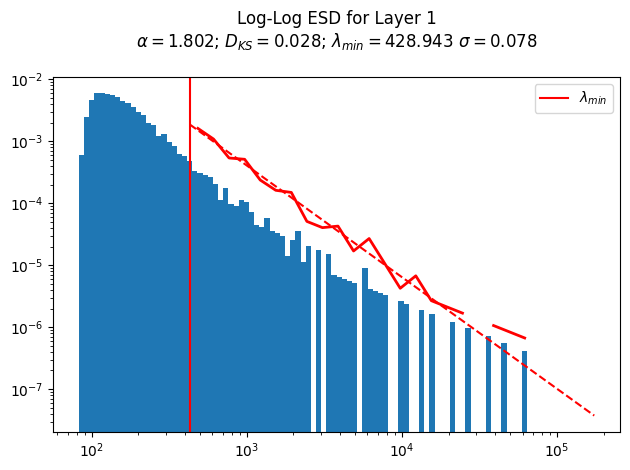

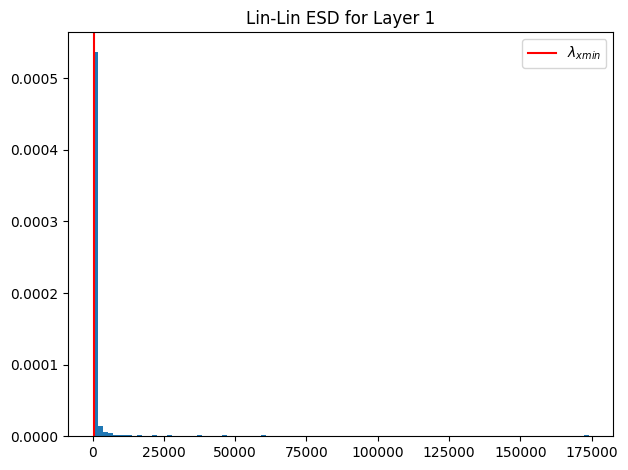

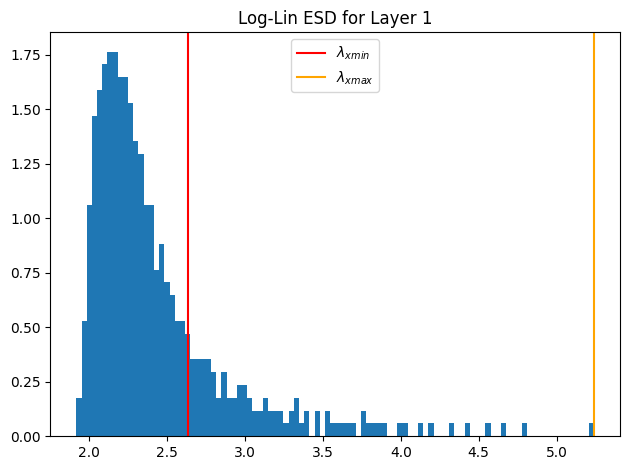

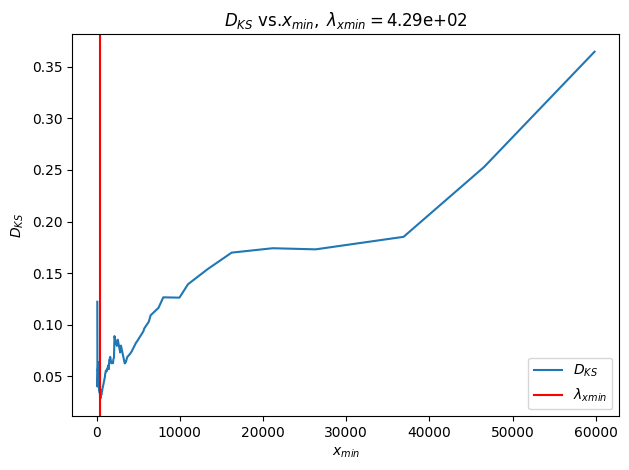

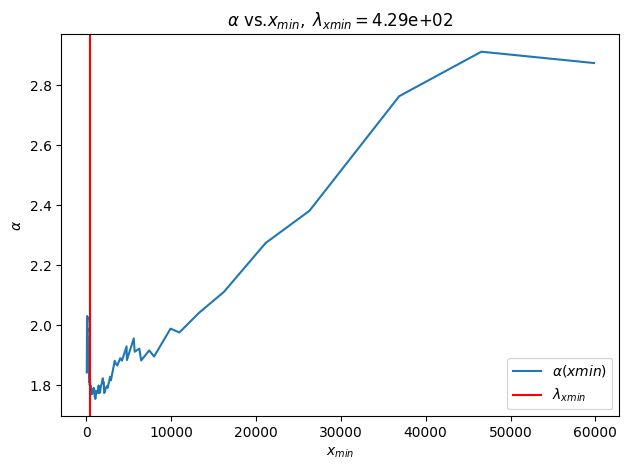

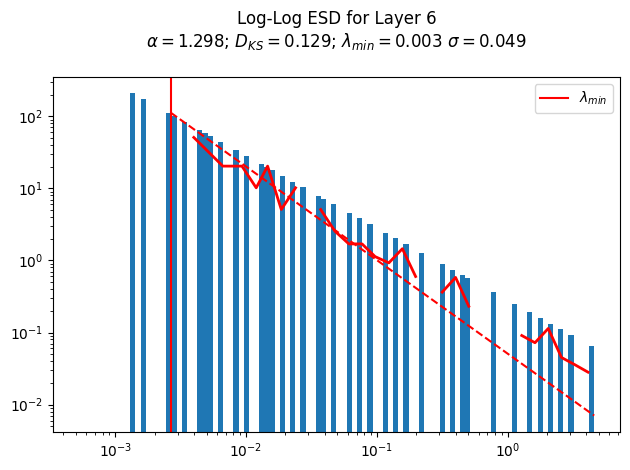

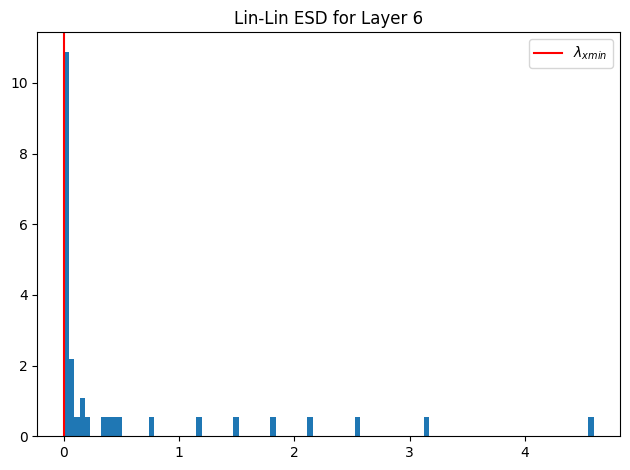

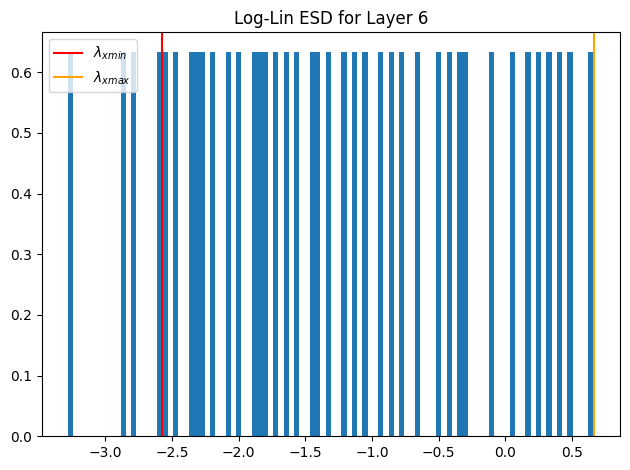

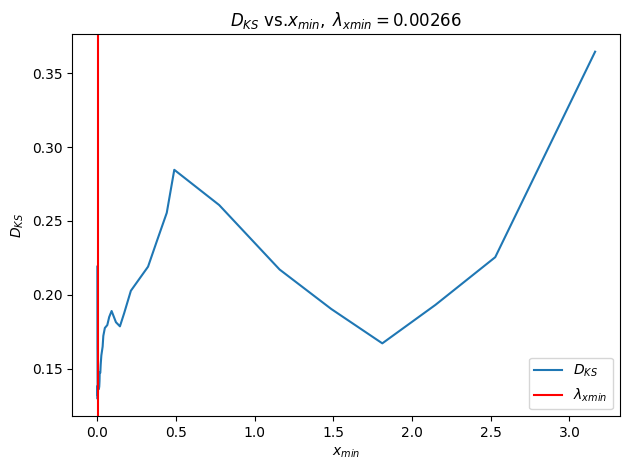

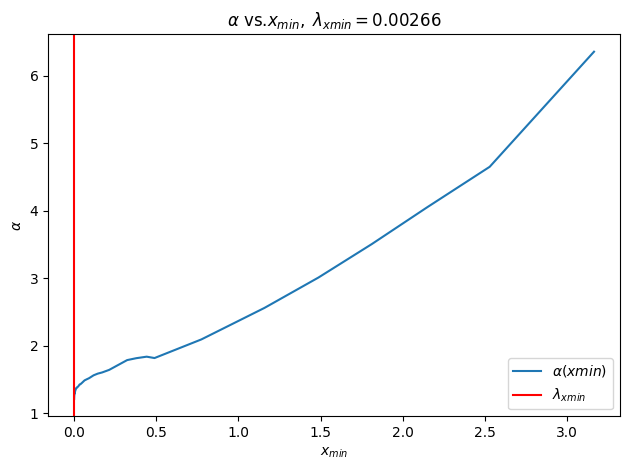

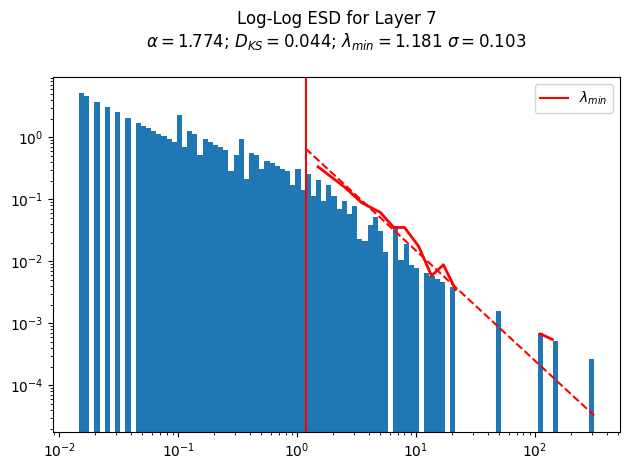

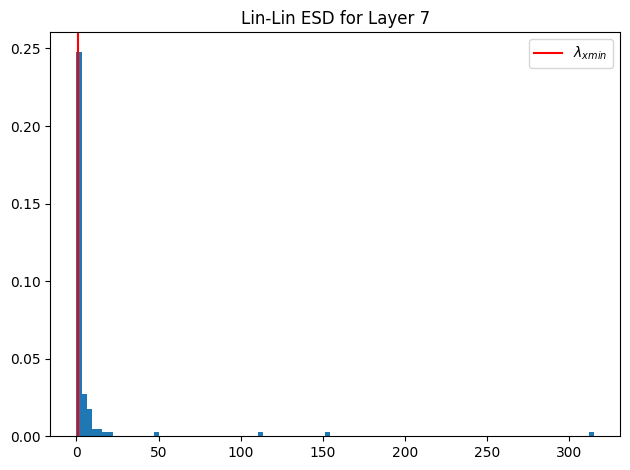

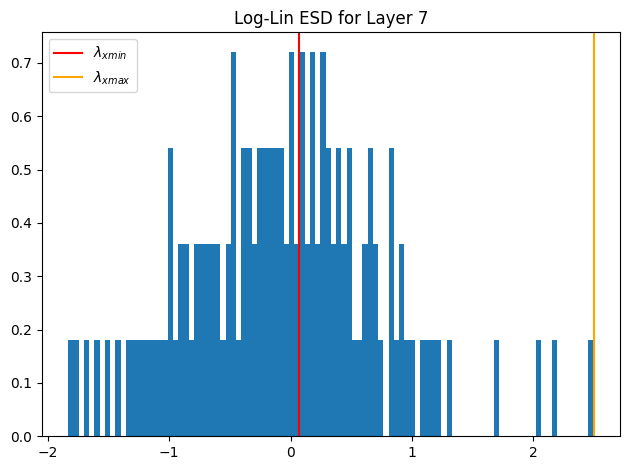

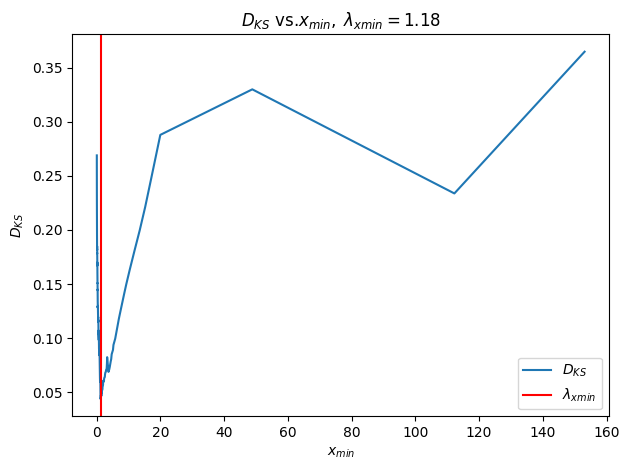

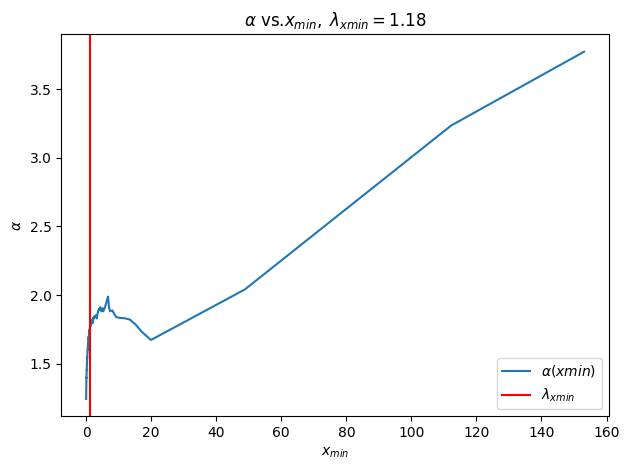

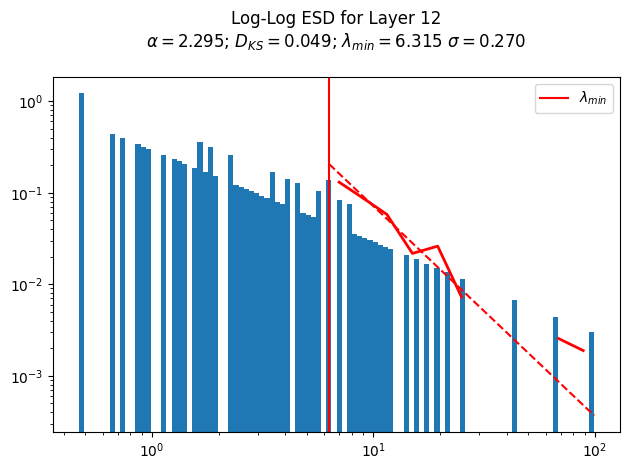

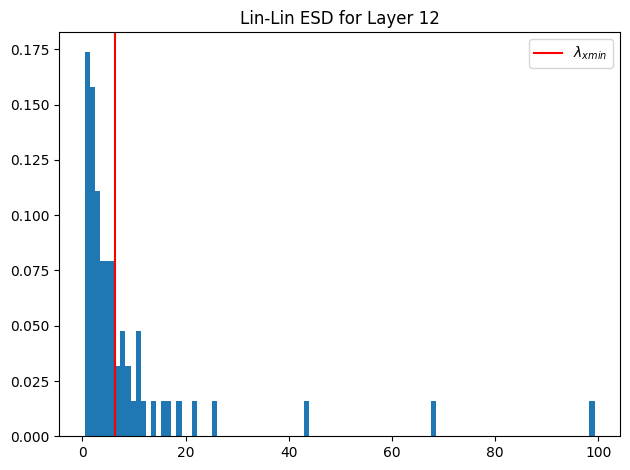

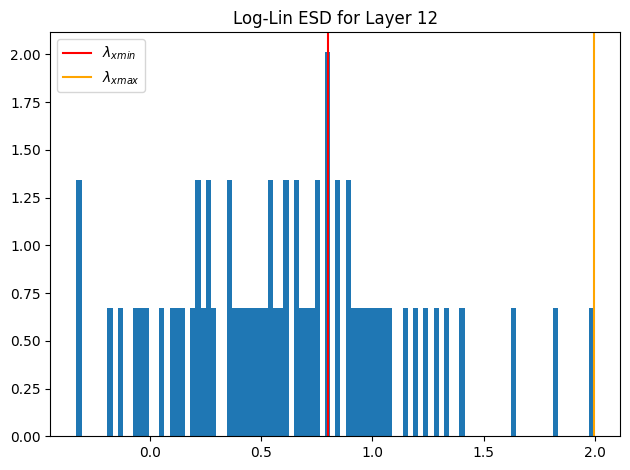

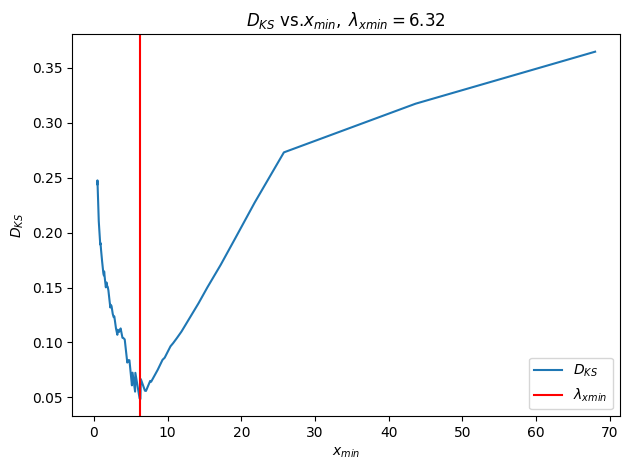

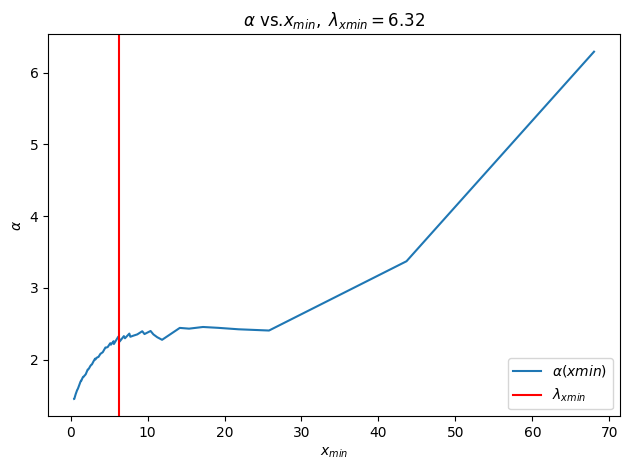

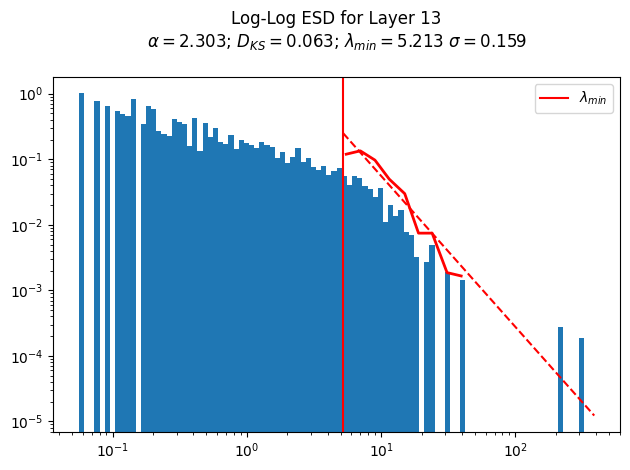

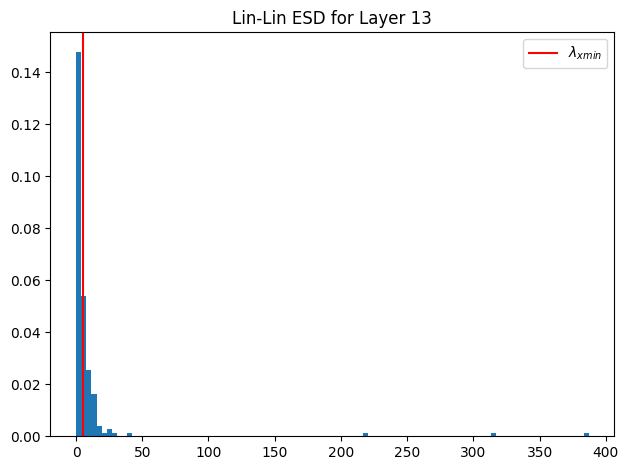

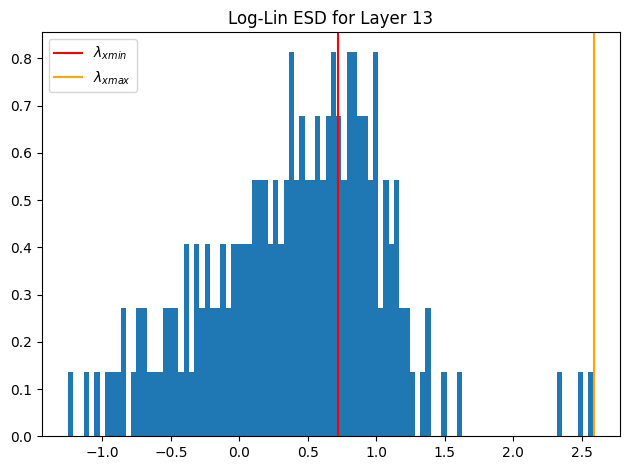

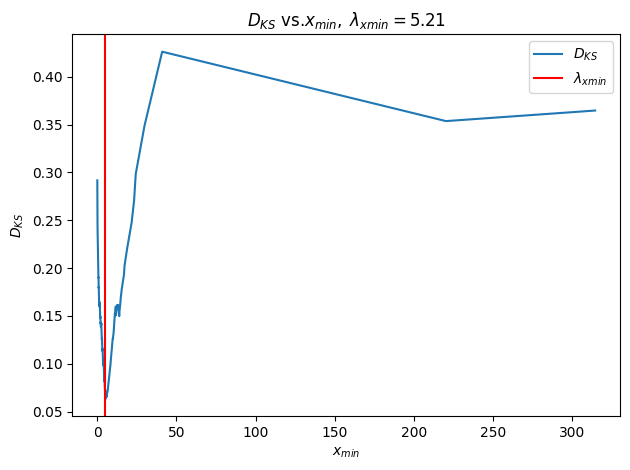

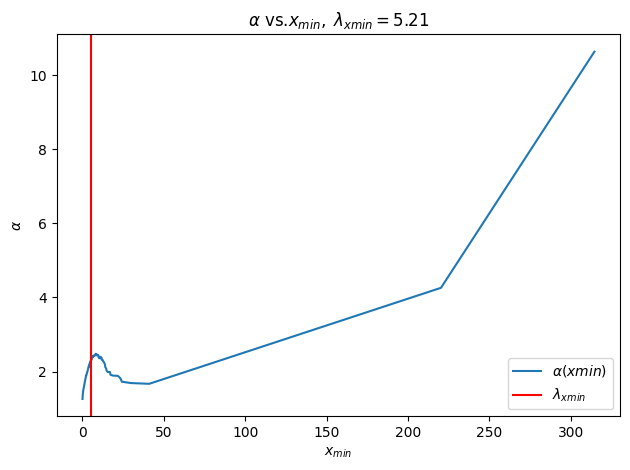

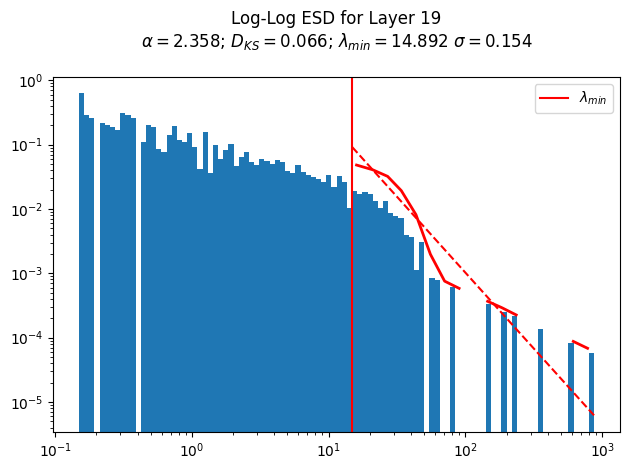

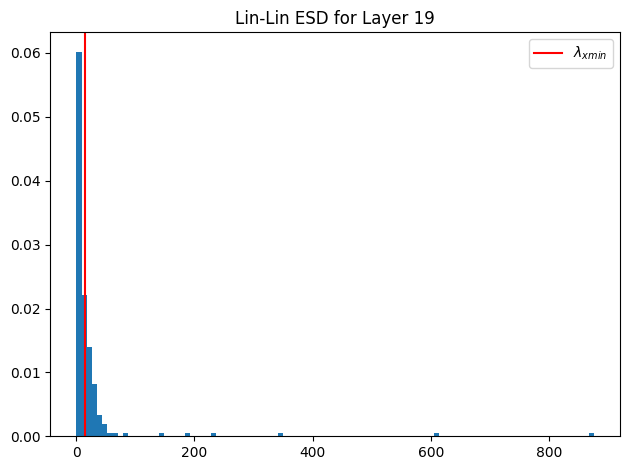

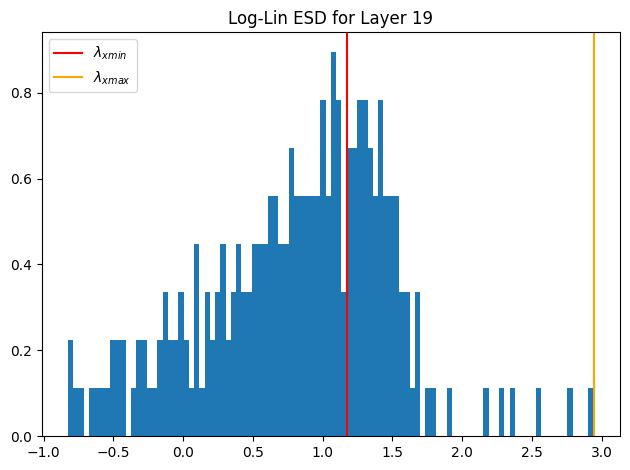

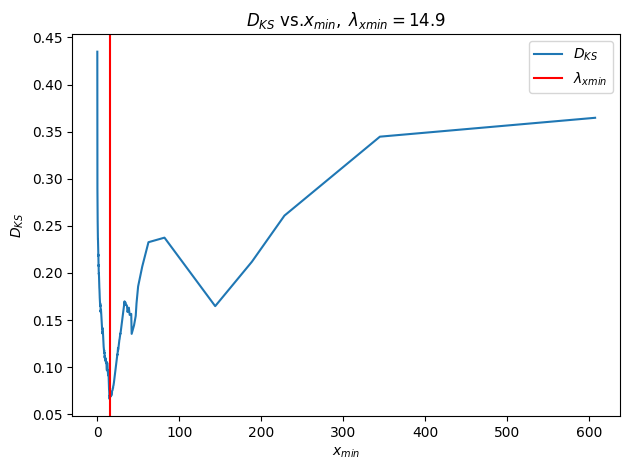

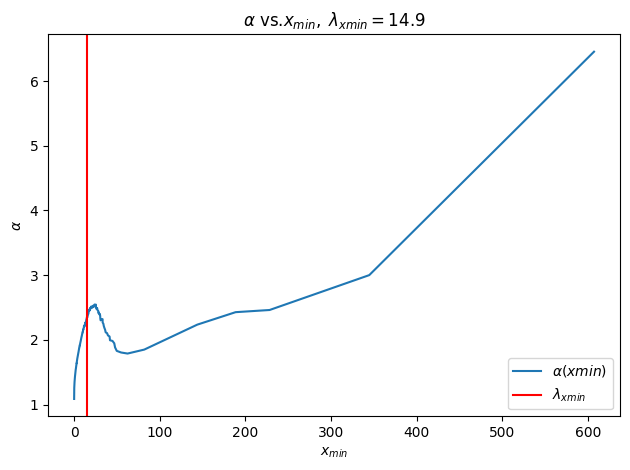

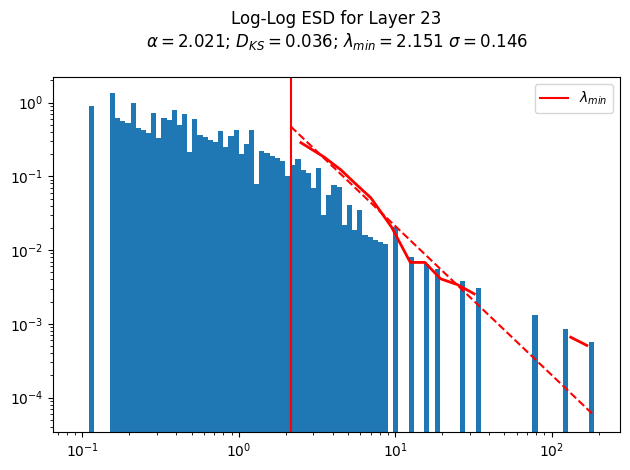

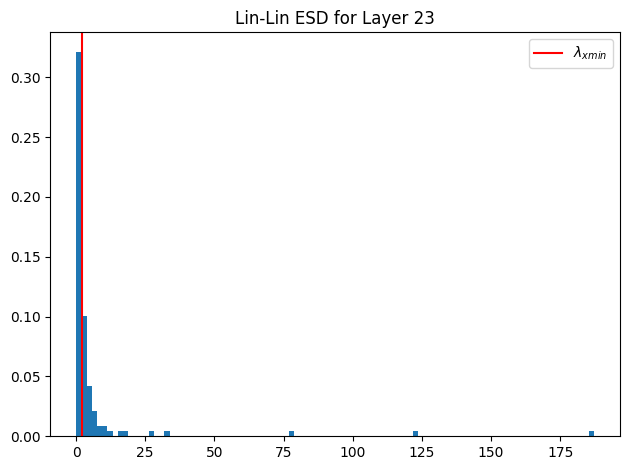

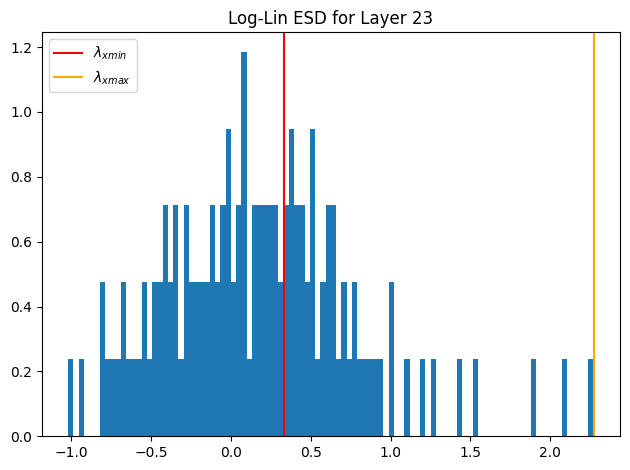

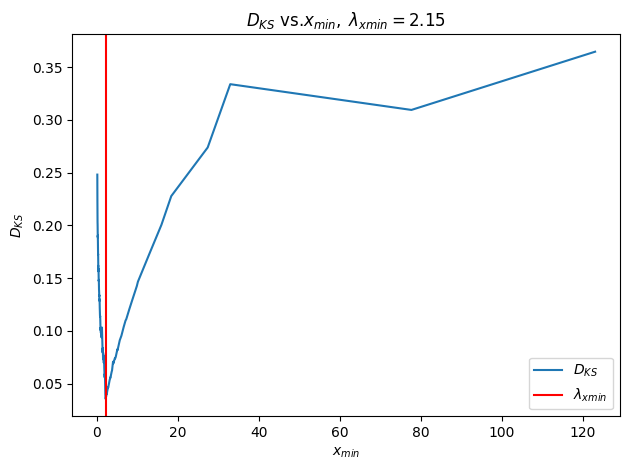

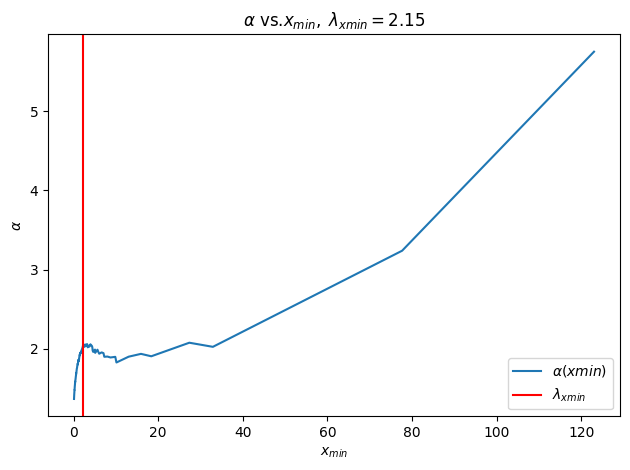

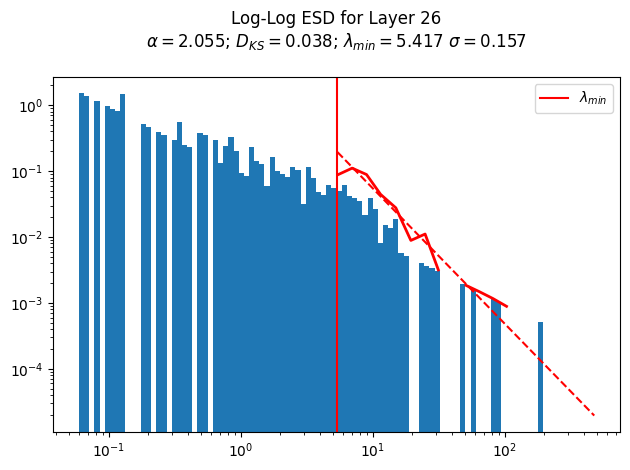

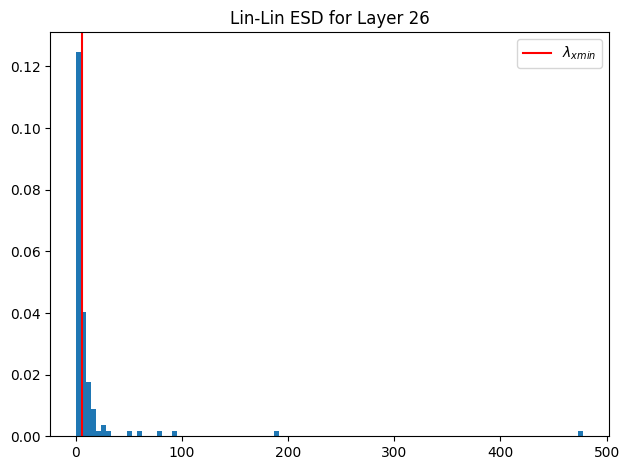

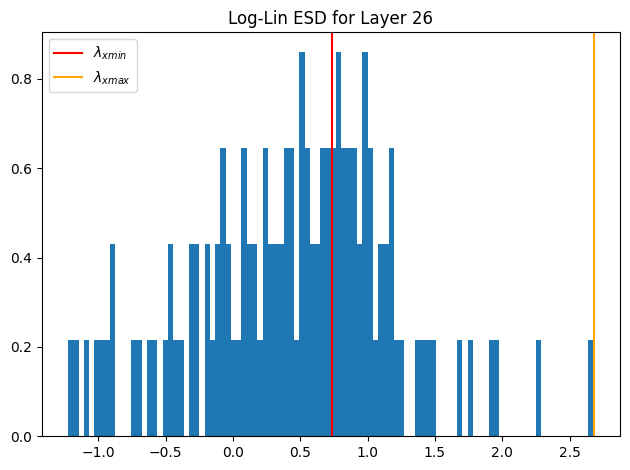

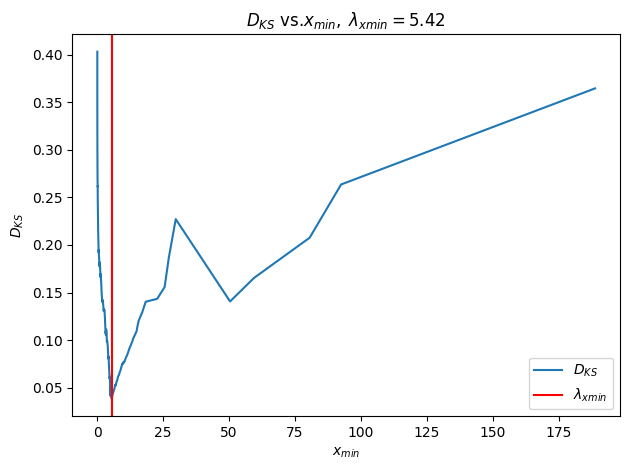

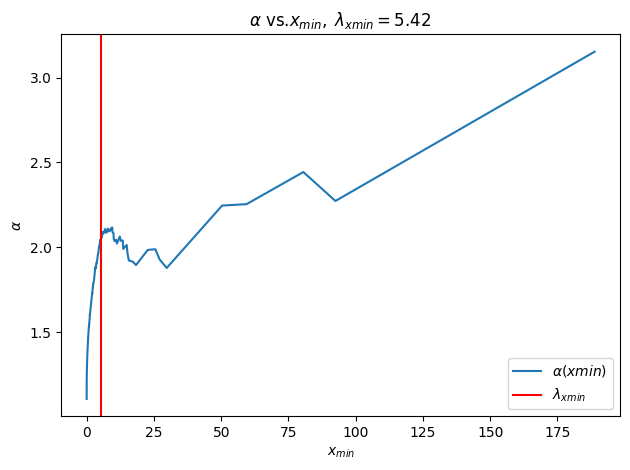

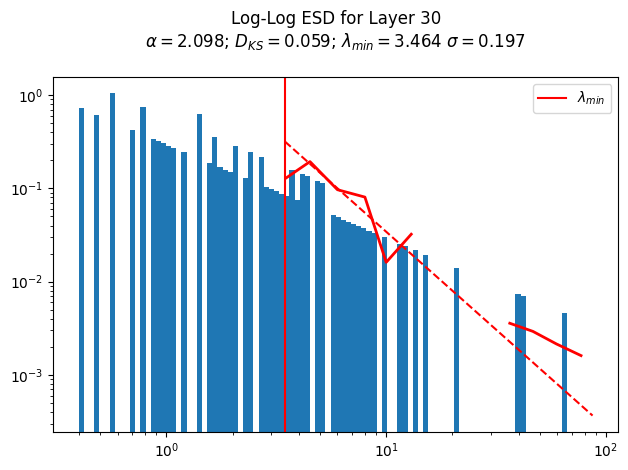

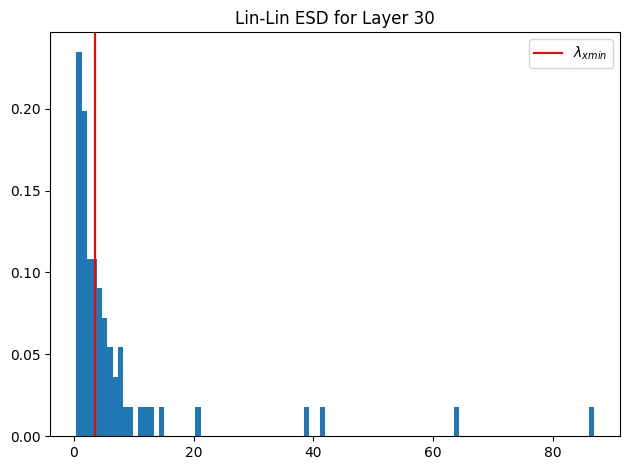

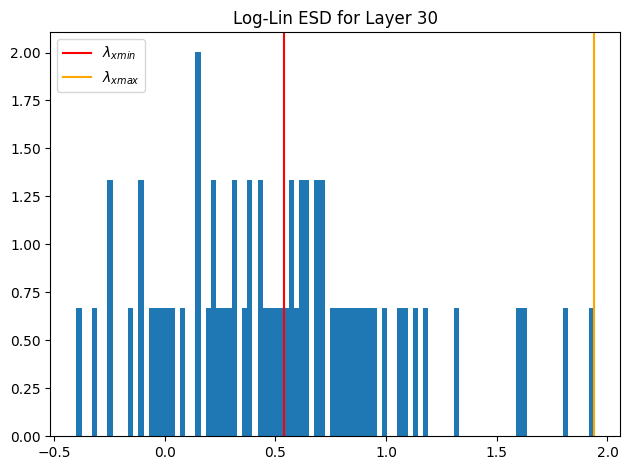

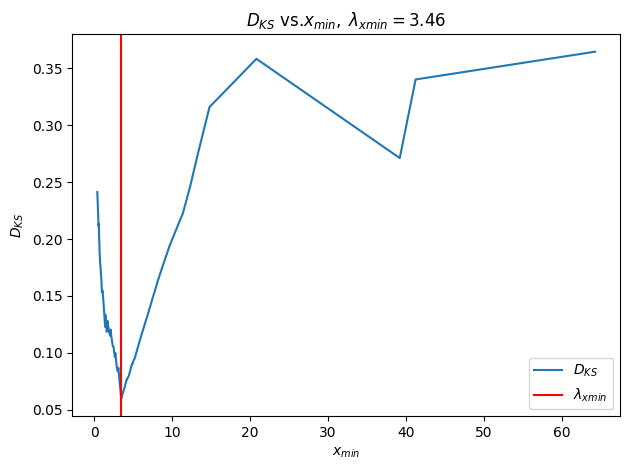

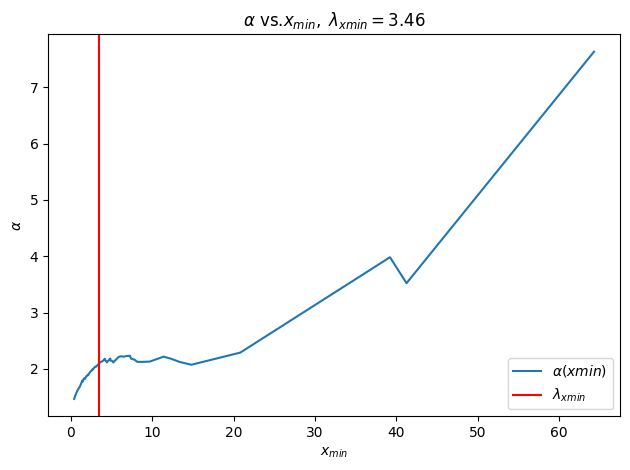

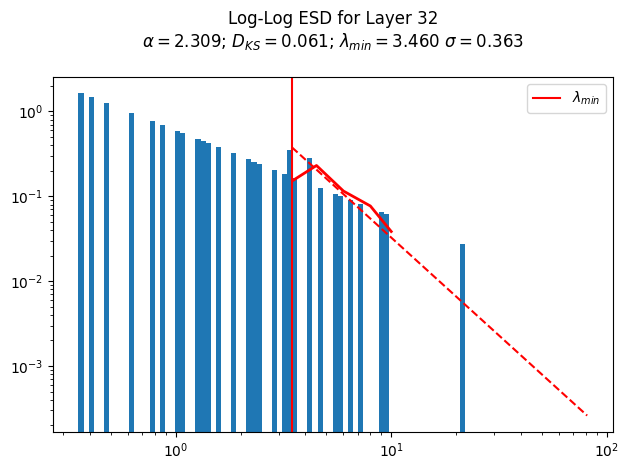

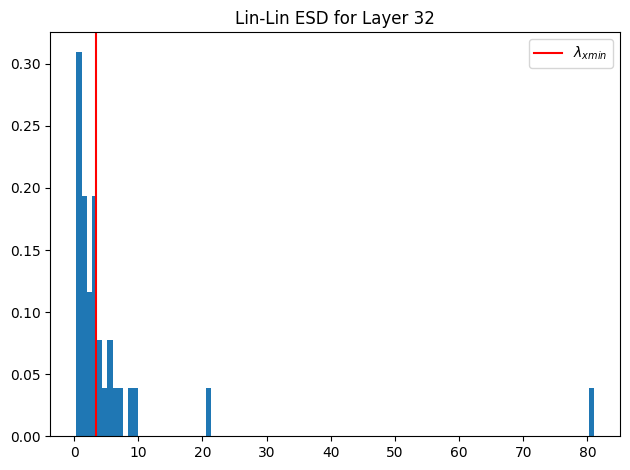

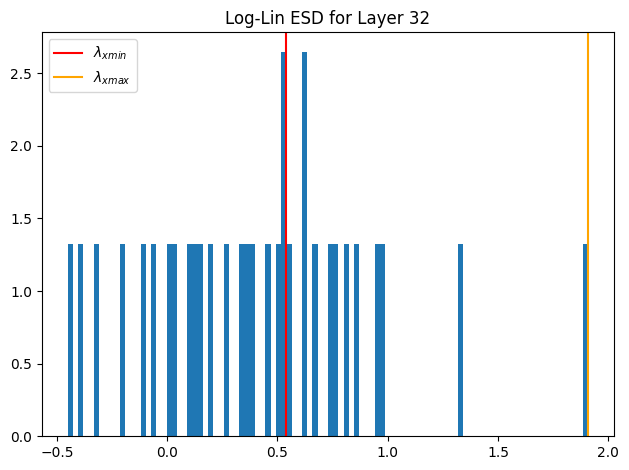

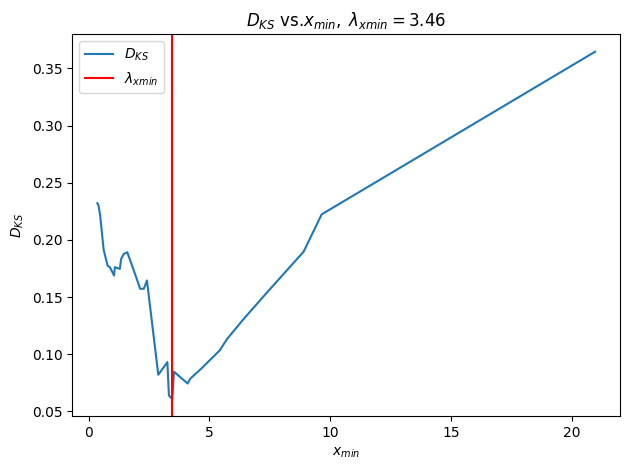

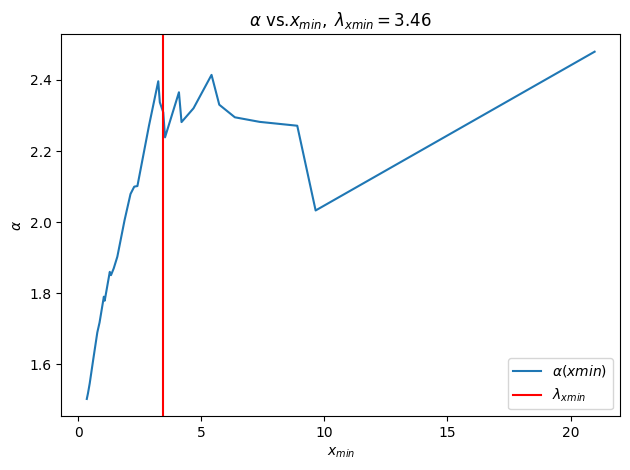

<Figure size 640x480 with 0 Axes>

In [32]:
watcher = ww.WeightWatcher(model=model)
details = watcher.analyze(plot=True)

summary = watcher.get_summary(details)

In [33]:
summary

{'log_norm': np.float64(3.0828015845723926),
 'alpha': np.float64(2.031141796826034),
 'alpha_weighted': np.float64(5.078510633164634),
 'log_alpha_norm': np.float64(5.310971184098453),
 'log_spectral_norm': np.float64(2.4727547530302667),
 'stable_rank': np.float64(4.242846579272219)}

# Визуализация метрик

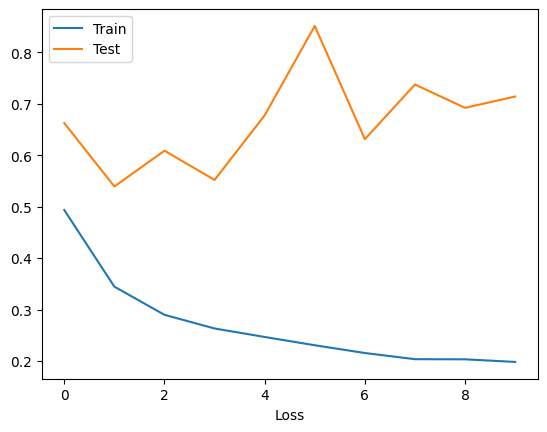

In [34]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('Epoch')
plt.xlabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

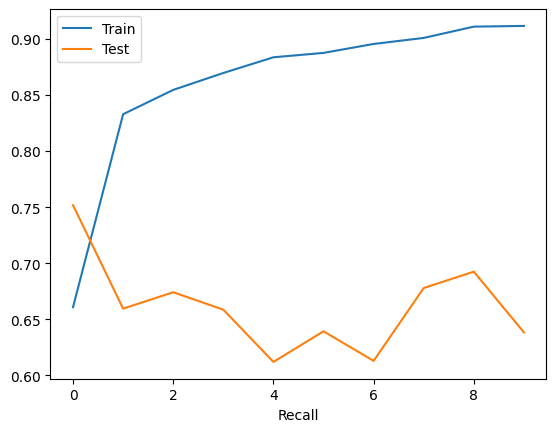

In [36]:
plt.plot(hist.history['recall_5'])
plt.plot(hist.history['val_recall_5'])
plt.xlabel('Epoch')
plt.xlabel('Recall')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

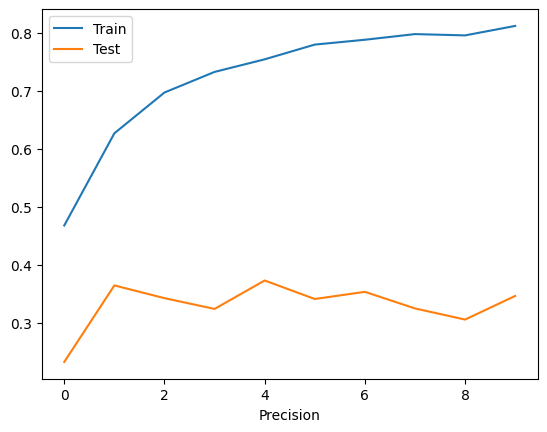

In [37]:
plt.plot(hist.history['precision_5'])
plt.plot(hist.history['val_precision_5'])
plt.xlabel('Epoch')
plt.xlabel('Precision')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Визуализация модели

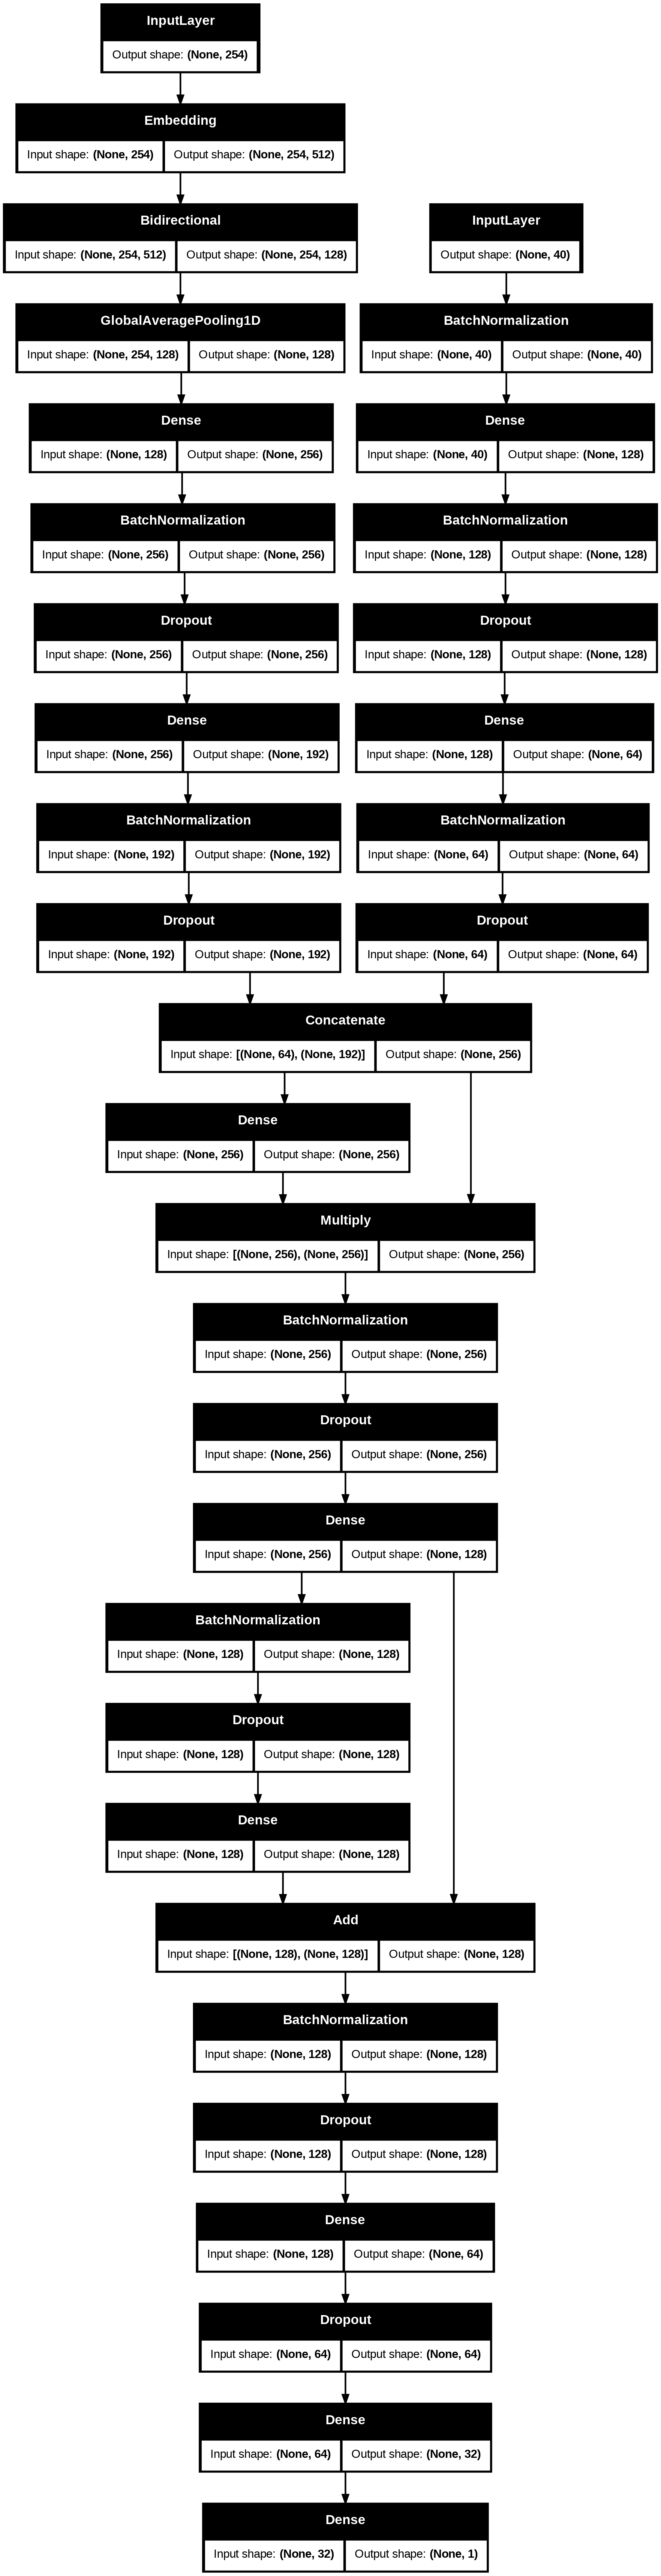

In [38]:
keras.utils.plot_model(model, "Model_structure.png", show_shapes=True)

# Сохранение модели

In [39]:
model.save_weights('model.weights.h5')

In [40]:
json_config = model.to_json()
with open("архитектура.json", "w") as f:
    f.write(json_config)

In [41]:
model.save("model.keras")

# Submission

In [42]:
df_test = pd.read_csv("ml_ozon_╤Бounterfeit_test.csv")

In [43]:
print('Кол-во пропусков:\n')
print(df_test.isna().sum(), "\n\n")
print("Размерность датасета:")
print(df_test.shape)

Кол-во пропусков:

id                                  0
brand_name                       5832
description                      2224
name_rus                            0
CommercialTypeName4                 0
rating_1_count                  21053
rating_2_count                  21053
rating_3_count                  21053
rating_4_count                  21053
rating_5_count                  21053
comments_published_count        21053
photos_published_count          21053
videos_published_count          21053
PriceDiscounted                     3
item_time_alive                     0
item_count_fake_returns7            0
item_count_fake_returns30           0
item_count_fake_returns90           0
item_count_sales7                   0
item_count_sales30                  0
item_count_sales90                  0
item_count_returns7                 0
item_count_returns30                0
item_count_returns90                0
GmvTotal7                        1381
GmvTotal30                     

In [44]:
df_test['brand_name'] = df_test['brand_name'].fillna("")
df_test['description'] = df_test['description'].fillna("")
df_test['rating_1_count'] = df_test['rating_1_count'].fillna(0.5)
df_test['rating_2_count'] = df_test['rating_2_count'].fillna(0.5)
df_test['rating_3_count'] = df_test['rating_3_count'].fillna(0.5)
df_test['rating_4_count'] = df_test['rating_4_count'].fillna(0.5)
df_test['rating_5_count'] = df_test['rating_5_count'].fillna(0.5)
df_test['comments_published_count'] = df_test['comments_published_count'].fillna(0.5)
df_test['photos_published_count'] = df_test['photos_published_count'].fillna(0.5)
df_test['videos_published_count'] = df_test['videos_published_count'].fillna(0.5)
df_test['GmvTotal7'] = df_test['GmvTotal7'].fillna(0.5)
df_test['GmvTotal30'] = df_test['GmvTotal30'].fillna(0.5)
df_test['GmvTotal90'] = df_test['GmvTotal90'].fillna(0.5)
df_test['ExemplarAcceptedCountTotal7'] = df_test['ExemplarAcceptedCountTotal7'].fillna(0.5)
df_test['ExemplarAcceptedCountTotal30'] = df_test['ExemplarAcceptedCountTotal30'].fillna(0.5)
df_test['ExemplarAcceptedCountTotal90'] = df_test['ExemplarAcceptedCountTotal90'].fillna(0.5)
df_test['OrderAcceptedCountTotal7'] = df_test['OrderAcceptedCountTotal7'].fillna(0.5)
df_test['OrderAcceptedCountTotal30'] = df_test['OrderAcceptedCountTotal30'].fillna(0.5)
df_test['OrderAcceptedCountTotal90'] = df_test['OrderAcceptedCountTotal90'].fillna(0.5)
df_test['ExemplarReturnedCountTotal7'] = df_test['ExemplarReturnedCountTotal7'].fillna(0.5)
df_test['ExemplarReturnedCountTotal30'] = df_test['ExemplarReturnedCountTotal30'].fillna(0.5)
df_test['ExemplarReturnedCountTotal90'] = df_test['ExemplarReturnedCountTotal90'].fillna(0.5)
df_test['ExemplarReturnedValueTotal7'] = df_test['ExemplarReturnedValueTotal7'].fillna(0.5)
df_test['ExemplarReturnedValueTotal30'] = df_test['ExemplarReturnedValueTotal30'].fillna(0.5)
df_test['ExemplarReturnedValueTotal90'] = df_test['ExemplarReturnedValueTotal90'].fillna(0.5)
df_test['ItemVarietyCount'] = df_test['ItemVarietyCount'].fillna(0.5)
df_test['ItemAvailableCount'] = df_test['ItemAvailableCount'].fillna(0.5)

df_test['PriceDiscounted'] = df_test['PriceDiscounted'].fillna(0.5)

In [45]:
df_vectors_test = df_test[df_test.columns[5:]]
df_vectors_test['id'] = df_test['id']

/tmp/ipython-input-3614781818.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vectors_test['id'] = df_test['id']


In [46]:
df_fit_test = scaler.transform(df_vectors_test[[df_vectors_test.columns[i] for i in range(len(df_vectors_test.columns))]])

In [47]:
df_text_test = df_test['brand_name'] + ". " + df_test['description'] + ". " + df_test['name_rus'] + ". " + df_test['CommercialTypeName4']

In [48]:
text_data_test = tokenizer.texts_to_sequences(df_text_test)

text_train_test = pad_sequences(text_data_test, maxlen=254)     # 254 - максимальная длина элемента text_data

In [49]:
test_predictions = model.predict([df_fit_test, text_train_test]).reshape(1, -1)[0]
test_predictions = [round(x) for x in test_predictions]

submission = pd.DataFrame({
    'id': df_test['id'],
    'prediction': test_predictions
})
submission.to_csv('submission.csv', index=False)


print(f"Создан файл submission.csv с {len(submission)} предсказаниями")
print(f"Распределение предсказаний:")
print(submission['prediction'].value_counts())
print()

712/712 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step
Создан файл submission.csv с 22760 предсказаниями
Распределение предсказаний:
prediction
0    17422
1     5338
Name: count, dtype: int64



In [50]:
pd.read_csv('submission.csv')

,id,prediction
0,17384,0
1,260316,0
2,10610,0
3,205236,0
4,308655,1
...,...,...
22755,423002,0
22756,316386,0
22757,245410,0
22758,440579,0
